In [1]:
import argparse
import os
import sys
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F

from data.dataloader_custom import CustomLoader
from models.NNET import NNET
import utils.utils as utils

import matplotlib
import matplotlib.pyplot as plt

from torchvision import transforms

import cv2

In [14]:
def test(model, test_loader, device, results_dir):
    alpha_max = 60
    kappa_max = 30
    
    pred_norm = 0
    pred_norm_rgb = 0

    with torch.no_grad():
        for data_dict in tqdm(test_loader):

            img = data_dict['img'].to(device)
            norm_out_list, _, _ = model(img)
            norm_out = norm_out_list[-1]

            pred_norm = norm_out[:, :3, :, :]
            pred_kappa = norm_out[:, 3:, :, :]

            # to numpy arrays
            img = img.detach().cpu().permute(0, 2, 3, 1).numpy()                    # (B, H, W, 3)
            pred_norm = pred_norm.detach().cpu().permute(0, 2, 3, 1).numpy()        # (B, H, W, 3)
            pred_kappa = pred_kappa.cpu().permute(0, 2, 3, 1).numpy()


            # 1. save input image
            img = utils.unnormalize(img[0, ...])


            # 2. predicted normal
            pred_norm_rgb = ((pred_norm + 1) * 0.5) * 255
            pred_norm_rgb = np.clip(pred_norm_rgb, a_min=0, a_max=255)
            pred_norm_rgb = pred_norm_rgb.astype(np.uint8)                  # (B, H, W, 3)

        return pred_norm, pred_norm_rgb

In [15]:
class Args_for_input():
    def __init__(self):
        self.architecture = 'GN'
        self.pretrained = 'nyu'
        self.sampling_ratio = 0.4
        self.importance_ratio = 0.7
        self.input_height = 480
        self.input_width = 640
        self.imgs_dir = './examples'

# read arguments from txt file


args = Args_for_input()

device = torch.device('cuda:0')

# load checkpoint
checkpoint = './checkpoints/%s.pt' % args.pretrained
print('loading checkpoint... {}'.format(checkpoint))
model = NNET(args).to(device)
model = utils.load_checkpoint(checkpoint, model)
model.eval()
print('loading checkpoint... / done')

# test the model
results_dir = args.imgs_dir + '/results'
os.makedirs(results_dir, exist_ok=True)
test_loader = CustomLoader(args, args.imgs_dir).data
res, resplot = test(model, test_loader, device, results_dir)

loading checkpoint... ./checkpoints/nyu.pt
Loading base model ()...

Using cache found in C:\Users\gbekh/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
loading checkpoint... / done


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


In [16]:
res = res.squeeze()
resplot = resplot.squeeze()

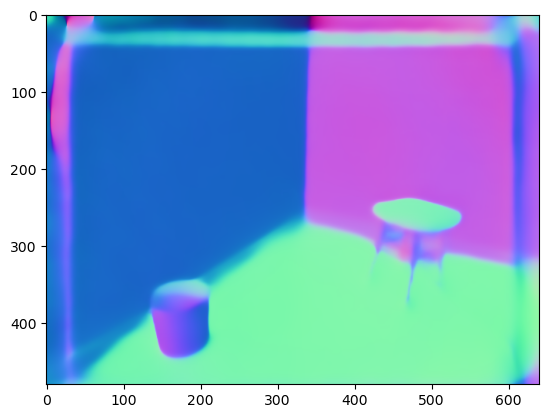

In [17]:
%matplotlib inline
plt.imshow(resplot)
plt.show()